# Class Project: Reconstructing Dates in Ancient Documents

## Introduction

Ancient documents are primary sources for reconstructing our histories. Yet ancient written sources, on papyri, ostraca, or clay cuneiform documents, are sometimes missing vital information, often due to damages on their physical surfaces. This missing information has to be reconstructed in order to properly understand and contextualize what the text once conveyed.

One of the most important pieces of information is the date in which a document is written. Some texts include date formula which give us an exact date (day, month, and year). These are vital to position the information the text holds in its correct historical context, and the specificity of the date is particularly important when studying micro-history of specific individuals, or micro historical events.

The cuneiform writing system specifically - arguably the earliest writing system developed, used from the 4<sup>th</sup> millennium BCE until the early years of the Common Era - was developed initially for record keeping and administration, and in these types of texts it was common to include the date. These are a particularly rich source for the micro-history of individuals, as we can find the same people, in different roles, with different titles, reappearing in different points during their life.

However, the clay tablets on which these documents are written are thousands of years old, and they are sometimes broken or abrated. This means that the dates are not always preserved. Prosopography, the study and disambiguation of individuals, is often a big factor used to reconstruct and assign tentative dates to documents in which this information is missing. This method, in its simplest form, means looking at all the individuals mentioned in a document; seeing if they are also attested elsewhere, in dated documents; and assigning a tentative date to the document based on the shared years of the mentioned individuals.

In practicality, other factors are taken into account, such as the roles or titles with which the individuals are mentioned in the texts, which they could only have gained from a certain point in their lives; other clues from the text that could indicate its date beside the people; or more weight could be put on the active years of one individual over another, depending on their centrality. Furthermore, one can often reach circular reasoning when assigning dates due to presuppositions. 

For this project, I would like to assess whether it is possible to reach objective correct estimates for documents based solely on the known years of activity of the individuals mentioned within them. I want to test this on cuneiform tablets with preserved dates, in which the individuals are disambiguated - meaning their various attestations in multiple documents are grouped under a common ID.

An important digital prospographical resource for ancient cuneiform documents is the [Prosobab project and Database](https://prosobab.leidenuniv.nl/). It is an open access prosopography of individuals who appear in cuneiform documents from 678-325 BCE. These documents are daily texts, primarily legal documents. For the tablets available in the database, every person attested in a document is a case, and different attestations of the same person are linked via a common ID (termed PID in the database columns). This database allows for a large quantitative evaluation of the wide-spread methodology of using prosopography - disambiguated individuals - for reconstructing missing dates in historical documents.

In order to assess this, I take the following steps:
- filter the cases in the database to keep only those with fully preserved dates
- store all the years of activity for each disambiguated individual in the database in a dictionary. Remove ranges that are above a certain limit that is not realistic or not indicative (see further below)
- for each document, find the overlap in the years of activity between all the individuals, without taking into consideration the date of the current document
- create a range (a list) of the shared years, and calculate the mean and median of that range.
- measure the distance from the range, mean, and median to the real date of the document

For the purpose of this experiment, I would consider it successful if more than 90% of the texts are successfully identified through the mean or median within ten years of the real date, or, within five years of the range as long as the range itself is no longer than five years.

Previously, computational studies on the Prosobab database have been used primarily to perform social network analysis, i.e., understanding the relationships between individuals, identifying key figures, etc. (see for example [guidelines for downloading Prosobab data for creating a social network in Gephi](http://persiababylonia.org/archives/methods/gephi-guidelines-for-cuneiform-archives-part-1-acquiring-a-dataset-via-prosobab/)). The study here is the first of its kind on the Prosobab data and on cuneiform cultural heritage at large, to my knowledge.

## Importing Packages and Defining Functions

The functions are used later on in their notebook, where it is explained exactly what they do.

In [1]:
# Importing the necessary packages
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px

In [2]:
# helper function to get statistics to visualize and save space
def get_mean_and_median(value):
    return (round(np.mean(value), 2), round(np.median(value), 2))

In [3]:
# this function is used in the process_data function
def make_dict_for_pids_or_tablets(df, column_key, column_value):
    
    new_dict = {}
    keys_list = df[column_key].unique()

    for key in keys_list:
        key_df = df[df[column_key]==key]
        values = np.sort(np.unique(key_df[column_value].to_numpy()))
        new_dict[key] = values
    
    return new_dict

In [4]:
def preprocess_data(df):
    # Step 1: clean metadata columns that might be used later for visualization
    
    ## clean "type and objects" column to create a clean column with just the subtype
    df["Subtype"] = df["Type and objects"].astype("str").str.split("Subtype").str[1]
    
    # Step 2: remove dates that are not numbers
    # (that means they have markings which indicate they are not certain)
    
    ## checking which dates can be converted to integers,
    ## accordingly assigning them to good_dates and bad_dates.
    ## currently for dates with a slash, keeping the first date out of the two.
    good_dates = []
    bad_dates = []
    dates = df["Julian date"].unique()
    for date in dates:
        try:
            if "/" in date:
                date = date.split("/")[0]
            int(date)
    #             years = date.split("/")
    #             int(years[0])
    #             int(years[1])
    #         else:
    #             int(date)
            good_dates.append(date)
        except:
            bad_dates.append(date)
            
    ## use the good-dates list to mask the dataframe, 
    ## then, adding a minus ("-") character before each year so
    ## the numbers will be minuses when converting string to integer
    df_clean_dates = df[df["Julian date"].isin(good_dates)].copy()
    minus = np.array(["-"] * df_clean_dates.shape[0])
    df_clean_dates["Julian date"] = (minus + df_clean_dates["Julian date"]).astype("int")
    
    ## In later stages, I found three texts whose Julian dates were wrongly
    ## converted from the Babylonian dates, manually fixing the dates here
    df_clean_dates["Julian date"] = df_clean_dates["Julian date"].mask(df_clean_dates["Tablet ID"]==4873, -531)
    df_clean_dates["Julian date"] = df_clean_dates["Julian date"].mask(df_clean_dates["Tablet ID"]==4834, -620)
    df_clean_dates["Julian date"] = df_clean_dates["Julian date"].mask(df_clean_dates["Tablet ID"]==7946, -551)
    
    # Step 3: clean Role column (remove none-present individuals, remove texts without pids, convert to int)

    ## turn Role column values into lists of multiple roles
    df_clean_dates["Role"] = df_clean_dates["Role"].str.split("\n")
    
    ## create a list with all unique role types
    ## (got explode() code from: https://stackoverflow.com/questions/58528989/pandas-get-unique-values-from-column-of-lists)
    roles = df_clean_dates["Role"].explode().unique()
    
    ## manually selected based on all roles in the above list
    non_present_roles = [
        "represented by agent",
        "husband (of woman acting)",
        "passive (mentioned in relation to sb or sth else)",
        "king in date",
        "absent/not present (ina lā ašābi)",
        "mentioned in letter",
        "king in oath",
        "absent/not present (lā pāni)",
        "king on coin"
    ]
    
    ## creating a new list with just the relevant (present) roles, by removing 
    ## the "non_present_roles" list items from the roles list.
    ## (np.setdiff1d found at https://stackoverflow.com/questions/10996140/how-to-remove-specific-elements-in-a-numpy-array)
    relevant_roles = np.setdiff1d(np.array(roles), np.array(non_present_roles))
    
    ## in order to remove non present roles, I use explode to create a new row
    ## in the DataFrame for every role an individual has in a given text.
    ## If a person has a relevant role, he will remain in the DataFrame.
    ## If not, he is completely removed.
    df_clean_dates = df_clean_dates.explode("Role")
    df_clean_dates_removed_roles = df_clean_dates[df_clean_dates["Role"].isin(relevant_roles)].copy()
    
    ## Removing rows that do not have PID (where it will equal "-")
    ## and converting the PID column type to integer.
    df_clean_dates_removed_roles = df_clean_dates_removed_roles[df_clean_dates_removed_roles["PID"]!="-"].copy()
    df_clean_dates_removed_roles["PID"] = df_clean_dates_removed_roles["PID"].astype("int")
    
    return df_clean_dates_removed_roles

In [5]:
def process_data(df_clean_dates_removed_roles, range_limit=50):
    
    # Step 4: create dictionary of PID and their years active

    pids_dict = make_dict_for_pids_or_tablets(df_clean_dates_removed_roles, "PID", "Julian date")
    
    ## check average range of person
    ## discovered: there were some Julian dates that were entered incorrectly (fixed in preprocessing)
    ## there are also some individuals who are identified as the same person even though they live for too long.
    ## these are put in a separate list of outliers.
    pid_ranges = []
    outliers = []
    for pid in pids_dict.keys():
        pid_range = np.abs(np.min(pids_dict[pid])) - np.abs(np.max(pids_dict[pid]))
        if pid_range >= range_limit:
            outliers.append(pid)
        else:
            pid_ranges.append(pid_range)

    ## Removing the outliers from the pids_dict
    [pids_dict.pop(key) for key in outliers]
    
    # Step 5: create dictionary of tablets and their PIDs and a new DataFrame

    tablets_dict = make_dict_for_pids_or_tablets(df_clean_dates_removed_roles, "Tablet ID", "PID")
    
    ## creating a new df where each case is a tablet (as opposed to a person)
    ## and keep only relevant columns
    tablet_df = df_clean_dates_removed_roles.drop_duplicates("Tablet ID")[[
        "Museum no.", "Publication", "Archive", "Type", "Date",
        "Julian date", "Place of writing", "Tablet ID", "Subtype"]]
    
    # Step 6: Calculate date estimates for each tablet.

    estimates = {}
    no_estimates = []

    for tablet in tablets_dict.keys():
        ## saving to a variable the known year of the tablet
        curr_year = tablet_df[tablet_df["Tablet ID"]==tablet]["Julian date"].values[0]
        ## saving to a variable the PIDs known in this tablet
        pids = tablets_dict[tablet]
        
        ranges = []

        for pid in pids:
            if pid in pids_dict.keys():
                ## setting to a variable the years of activity of this PID
                years = pids_dict[pid]
                ## removing the year of the current tablet from the years of activity
                years = np.setdiff1d(years, curr_year)
                ## checking the list of years is not empty
                ## before adding it to the ranges list.
                if len(years) != 0:
                    ranges.append(years)

        ## checking the ranges list is not empty
        if len(ranges) != 0:
            ## code line below from explanation on:
            ## https://www.geeksforgeeks.org/python-find-common-elements-in-list-of-lists/
            ## it finds all the common elements in a list of lists
            intersection = sorted(list(set.intersection(*map(set, ranges))))

            ## checking the intersection list is not empty
            ## (this would mean there are no shared years)
            if len(intersection) != 0:
                estimates[tablet] = {"range_top": np.min(intersection),
                                     "range_bottom": np.max(intersection),
                                     "mean": np.mean(intersection).astype("int"),
                                     "median": np.median(intersection).astype("int"),
                                     "range_length": np.abs(np.abs(np.min(intersection))-np.abs(np.max(intersection))),
                                     "num_pids": len(pids),
                                     "real_range": True}

            else:
                ## using Q₁ and Q₃ to create an artificial range
                ## turning a list of lists into a flat list
                flat_ranges = np.concatenate(ranges, axis=0)
                ## code line below from explanation on
                ## https://stackoverflow.com/questions/45926230/how-to-calculate-1st-and-3rd-quartiles
                
                if np.abs(np.min(flat_ranges)) - np.abs(np.max(flat_ranges)) >= range_limit:
                    no_estimates.append(tablet)
                    
                else:
                    quartiles = np.percentile(flat_ranges, [25, 50, 75]).astype("int")

                    estimates[tablet] = {"range_top": quartiles[0],
                                         "range_bottom": quartiles[2],
                                         "mean": np.mean(flat_ranges).astype("int"),
                                         "median": quartiles[1].astype("int"),
                                         "range_length": np.abs(np.abs(quartiles[0])-np.abs(quartiles[2])),
                                         "num_pids": len(pids),
                                         "real_range": False}

        ## if no pids had an active year except the year of the current tablet.
        else:
            no_estimates.append(tablet)
            
    # Step 7: converting dictionary to DataFrame and merge
    
    estimates_df = pd.DataFrame.from_dict(estimates, orient="index").reset_index()
    ## merge dataframes and remove tablets that do not have a range
    tablet_estimates = tablet_df.merge(estimates_df, how="right", left_on="Tablet ID", right_on="index").drop(
        "index", axis=1)
    
    return (tablet_estimates, pid_ranges, outliers, no_estimates)

In [6]:
def measure_distance_from_date(tablet_estimates):
    
    # Step 8: measure distances from real year
    
    ## from mean and median
    tablet_estimates["distance2mean"] = np.abs(np.abs(tablet_estimates["Julian date"]) - 
                                               np.abs(tablet_estimates["mean"]))
    tablet_estimates["distance2median"] = np.abs(np.abs(tablet_estimates["Julian date"]) - 
                                                 np.abs(tablet_estimates["median"]))
    ## checking if the real date is inside the range
    tablet_estimates["date_in_range"] = (tablet_estimates["range_top"] < tablet_estimates["Julian date"]) &(tablet_estimates["Julian date"] < tablet_estimates["range_bottom"])
    
    ## where the date is in range, the value is 0
    ## else, the value is the minimum distance from the top or bottom range.
    ## using np.minimum instead of np.min:
    ## https://www.tutorialspoint.com/compare-two-arrays-and-return-the-element-wise-minimum-in-numpy
    tablet_estimates["distance2range"] = np.where(tablet_estimates["date_in_range"]==False, 
                                                               np.minimum(
                                np.abs(np.abs(tablet_estimates["Julian date"]) - np.abs(tablet_estimates["range_top"])),
                                np.abs(np.abs(tablet_estimates["Julian date"]) - np.abs(tablet_estimates["range_bottom"]))
                                ), 0)
    return tablet_estimates

In [7]:
def check_optimal_range_limit(preprocessed_df, min_range=5, max_range=85, jump=5):

    outliers_lst, no_estimates_lst, distance2means, distance2medians, distance2ranges, succ_perc_from_mean, succ_perc_from_median, succ_perc_from_range = ([] for i in range(8))
    
    # looping through maximum range values from 5 to 80 in jumps of 5
    for i in range(min_range, max_range, jump):
        
        # processing the data with the current range_limit
        tablet_estimates, pid_ranges, outliers, no_estimates = process_data(preprocessed_df, range_limit=i)
        # getting tablet estimates
        tablet_estimates = measure_distance_from_date(tablet_estimates)
        
        # appending current values to lists
        outliers_lst.append(len(outliers))
        no_estimates_lst.append(len(no_estimates))

        distance2means.append(np.mean(tablet_estimates["distance2mean"]))
        distance2medians.append(np.mean(tablet_estimates["distance2median"]))
        distance2ranges.append(np.mean(tablet_estimates["distance2range"]))

        succ_perc_from_mean.append(np.mean(tablet_estimates["distance2mean"] <= 10))
        succ_perc_from_median.append(np.mean(tablet_estimates["distance2median"] <= 10))
        succ_perc_from_range.append(np.mean((tablet_estimates["distance2median"] <= 5) & (tablet_estimates["range_length"] <= 5)))
        
    # saving results of all runs to a DataFrame and returning it
    results = pd.DataFrame({"Range Limit": range(min_range, max_range, jump),
                            "Distance to Mean": distance2means,
                            "Distance to Median": distance2medians,
                            "Distance to Range": distance2ranges,
                            "Outliers": outliers_lst,
                            "No Estimates": no_estimates_lst,
                            "Success Percentage from Mean": succ_perc_from_mean,
                            "Success Percentage from Median": succ_perc_from_median,
                            "Success Percentage from Range": succ_perc_from_range})
    
    return results

## Data wrangling: filtering uncertain years, non-active roles, and calculating date estimates

In this section I upload the database; I clean some of its columns; I remove cases with uncertain years; I remove individuals who appear in non-active roles in the document, meaning, they were not necessarily present (or alive) at the time of its drafting; and I calculate the estimated range, mean, and median for each document based on the shared years of activity of its individuals.

The data from prosobab cannot be downloaded all at once, but rather by filtering certain datapoints in the search. So, the data was extracted into several CSV files that are stored under the folder `data`. In the code below I join these to one DataFrame.

In [8]:
# uploading the csvs from the data folder, cleaning NaN values
df = pd.DataFrame()
files = glob.glob("data/*.csv")
for file in files:
    file_df = pd.read_csv(file, encoding="utf-8")
    df = pd.concat([df, file_df])
df = df.fillna("-")

In the code block below, you can see the shape of the DataFrame and its more important columns, including the `Date`, which is the Babylonian date (day, month in Roman numerals, regnal year, and king), and `Julian date` which is the year of the document converted to the Julian calendar. There is other important information such as the type of document, the archive to which it belonged, the role of the individual in the document, and the probability of their identification.

Before any filtering, the database has 43,746 thousands cases. This means 43,746 unique attestations of individuals.

In [9]:
pd.set_option('display.max_columns', None)
print(df.shape)
df[["ind.Name", "PID", "Probability", "Role", "Tablet ID", "Date", "Julian date"]].iloc[:3]

(43746, 31)


,ind.Name,PID,Probability,Role,Tablet ID,Date,Julian date
0,Marduk-nāṣir-apli,5,probable,creditor,33,30.VII.- -,-
1,Kalbāya,17,less probable,creditor\nrecipient,6973,-,-
2,Madānu-bēlu-uṣur,18,highly probable,broken/unclear,7101,22.II.07 Cam,523


In the code block below, I use the `preprocess_data` function (see Appendix). This function:
- cleans columns with problematic entries that include multiple information
- removes cases with uncertain or unknown dates. Then adds a minus before all the dates (for BCE years) and converts the `Julian date` column to `int`.
- removes attestations of individuals whose role in the document is a non-present role.

After this, there are 26,657 cases in the DataFrame.

In [10]:
preprocessed_df = preprocess_data(df)
print(preprocessed_df.shape)
preprocessed_df[["ind.Name", "PID", "Probability", "Role", "Tablet ID", "Date", "Julian date"]].iloc[:3]

(26657, 32)


,ind.Name,PID,Probability,Role,Tablet ID,Date,Julian date
2,Madānu-bēlu-uṣur,18,highly probable,broken/unclear,7101,22.II.07 Cam,-523
4,Madānu-bēlu-uṣur,18,probable,payer,7827,17.XI.11 Nbn,-544
7,Nabû-ahhē-iddin,21,highly probable,recipient,6995,04.IX.00 Ner,-559


In the code block below, I use the `process_data` function (see Appendix). This function:

- creates a dictionary where the keys are the PIDs (the IDs of disambiguated individuals) and the values are a numpy array of all the years in which they are attested (`pid_ranges`).
- some PIDs' ranges of years of activity are too long, which probably indicates mistakes in the database. Therefore, the function takes a `range_limit` parameter which filters PIDs with more than the given years of activity. For initial exploration of the dataset, this is set at 50 years. The outliers are stored in a separate list (`outliers`).
- creates another dictionary where the keys are the tablet IDs and the values are all the PIDs attested in the tablet.
- then the tablet ID dictionary is looped through, and ranges of shared years of activity are created. The mean and median of those ranges are calculated.
- if there are no shared years, an artifical range is created by taking the Q1 and Q3 of all the years of activity of PIDs in the document.
- if the artificial range is above the `range_limit`, it is filtered out as that is too wide a range to be meaningful, especially when artificial.
- tablets that do not have an estimate because they do not have PIDs attested or because the PIDs are not attested anywhere else (and therefore they do not have additional years, or a possible range of activity), or because the artificial range is too big, are stored in a separate list (`no_estimates`).
- finally, the function creates a new DataFrame where every row (or case) is a tablet (as opposed to an individual, as it was before), and creates additional columns which hold the estimates calculated (`tablet_estimates`).

In [11]:
tablet_estimates, pid_ranges, outliers, no_estimates = process_data(preprocessed_df, range_limit=50)
print(tablet_estimates.shape)
tablet_estimates[["Julian date", "range_top", "range_bottom", "mean", "median", "range_length", "num_pids", "real_range"]].iloc[:3]

(2725, 16)


,Julian date,range_top,range_bottom,mean,median,range_length,num_pids,real_range
0,-523,-528,-507,-517,-518,21,2,True
1,-544,-539,-495,-517,-519,44,14,True
2,-537,-564,-546,-552,-548,18,4,True


## Visualize the data: Primary Statistics on the Databse
 
Before jumping into testing the efficacy of the estimated dates, in this section I provide a general overview of the corpus after filtering: when are the texts dated, what are the average ranges of individuals' activities, and the average ranges of the resulting estimates.

Text(0.5, 0, 'Length of Estimated Range for Date')

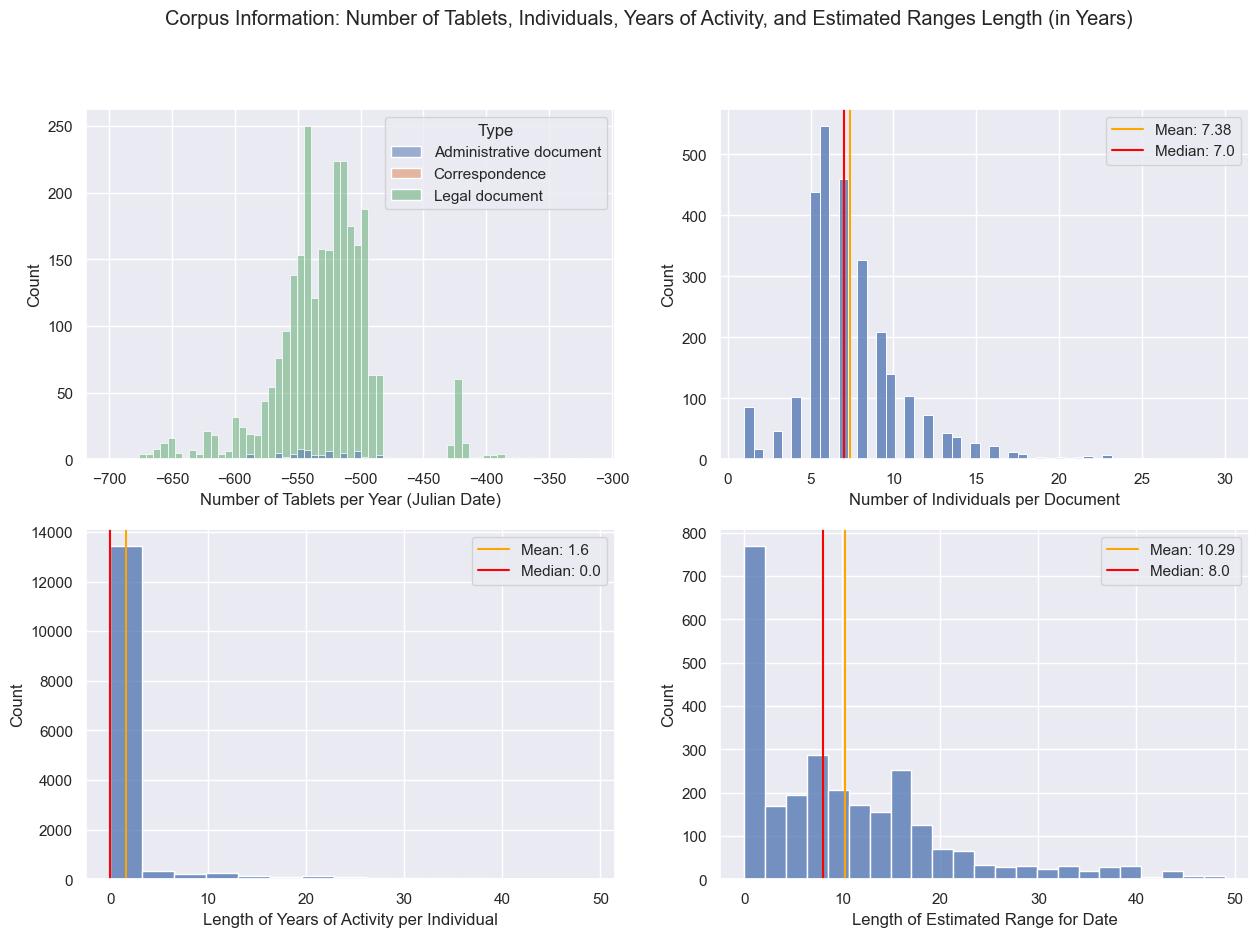

In [12]:
sns.set_theme()
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle("Corpus Information: Number of Tablets, Individuals, Years of Activity, and Estimated Ranges Length (in Years)")

ax00 = sns.histplot(tablet_estimates, x="Julian date", ax=ax[0, 0], hue="Type")
ax00.set_xlabel("Number of Tablets per Year (Julian Date)")

# there is one outlier text with 144 individuals. While interesting, it distorts the graph, and therefore is removed.
ax01 = sns.histplot(tablet_estimates[tablet_estimates["num_pids"]!=144], x="num_pids", ax=ax[0, 1])
pid_mean, pid_median = get_mean_and_median(tablet_estimates["num_pids"])
ax01.axvline(pid_mean, label=f"Mean: {pid_mean}", color="orange")
ax01.axvline(pid_median, label=f"Median: {pid_median}", color="red")
ax01.legend()
ax01.set_xlabel("Number of Individuals per Document")

ax10 = sns.histplot(pid_ranges, ax=ax[1, 0])
pid_rng_mean, pid_rng_median = get_mean_and_median(pid_ranges)
ax10.axvline(pid_rng_mean, label=f"Mean: {pid_rng_mean}", color="orange")
ax10.axvline(pid_rng_median, label=f"Median: {pid_rng_median}", color="red")
ax10.legend()
ax10.set_xlabel("Length of Years of Activity per Individual")

ax11 = sns.histplot(tablet_estimates, x="range_length", ax=ax[1, 1])
rng_mean, rng_median = get_mean_and_median(tablet_estimates["range_length"])
ax11.axvline(rng_mean, label=f"Mean: {rng_mean}", color="orange")
ax11.axvline(rng_median, label=f"Median: {rng_median}", color="red")
ax11.legend()
ax11.set_xlabel("Length of Estimated Range for Date")

As the above graphs show, the data in the corpus is not equally distributed. The range of the years for which we have dated tablets is heavily centered around the later 6<sup>th</sup> and 5<sup>th</sup> centuries BCE. This also reflects the fact that from this period we simply have more preserved tablets from Babylonia. In addition, the database primarily stores legal texts, with barely any other textual types present. There is, however, a nice distribution of number of individuals in each document. 

The lengths of years of activity per individual, however, are incredibly small. The median of these ranges is 0, meaning the grand majority of the individuals in the database, more than 13,000 of them, are only attested once, in one year, and therefore do not have a range. This means they were not taken at all into consideration when creating the estimated ranges. The fewer individuals that do provide meaningful ranges seem to potentially distort the estimated ranges too much for them to be indicative, as they are sometimes very long. These issues will resurface when testing the efficacy of the estimates in the following section.

## Analyses: Checking the Estimates

The code block below uses the `measure_distance_from_date` function (see Appendix). This function:

- measures the absolute distance of the mean and median from the real date
- checks if the real date is within the range - if it is, it stores the value 0 in a new column, if not, it stores the shortest distance from the real date, either the top or bottom of the range.

Text(0, 0.5, 'Range Length')

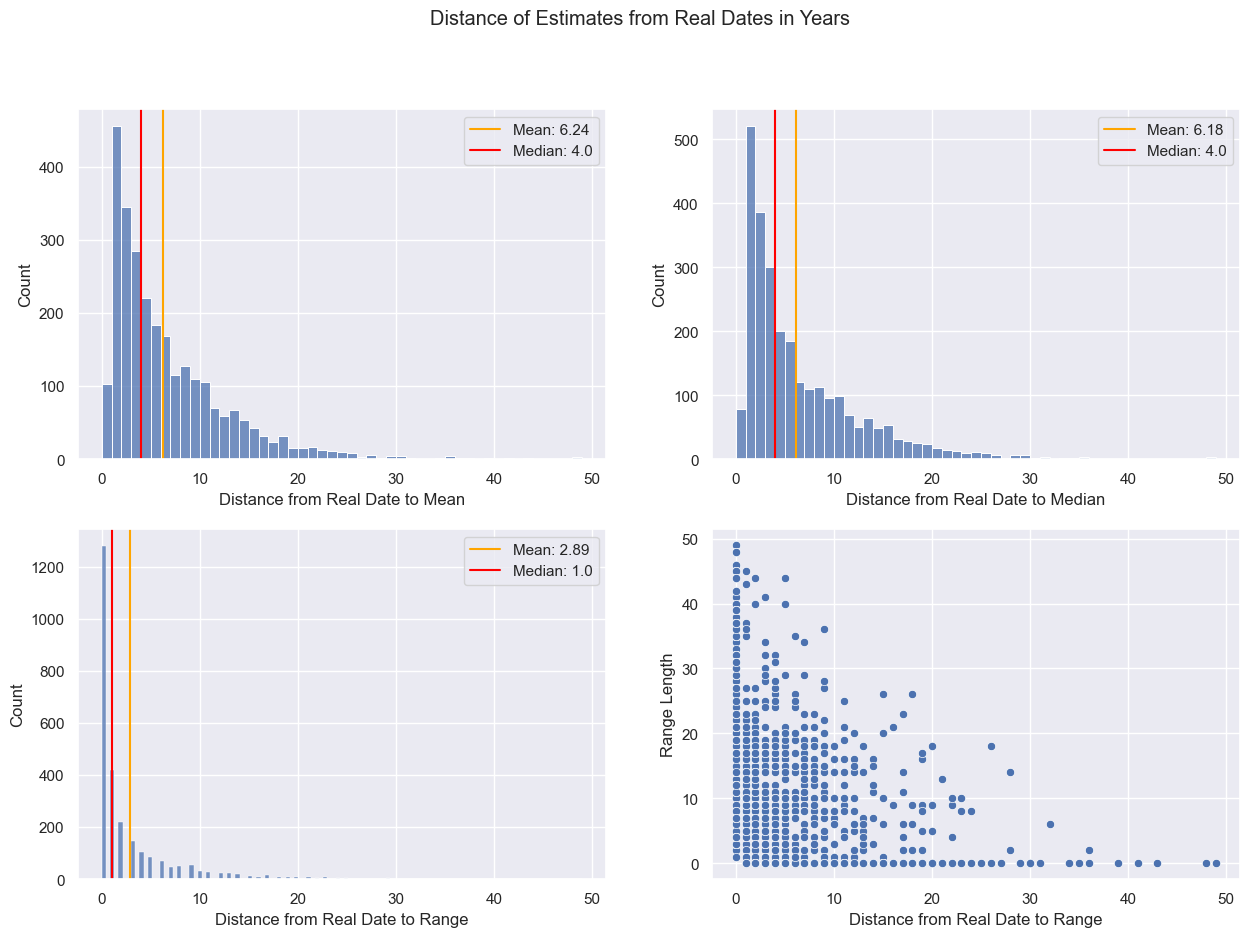

In [13]:
tablet_estimates = measure_distance_from_date(tablet_estimates)

fig, ax = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle("Distance of Estimates from Real Dates in Years")

ax00 = sns.histplot(tablet_estimates, x="distance2mean", ax=ax[0, 0])
dis_mean_mean, dis_mean_median = get_mean_and_median(tablet_estimates["distance2mean"])
ax00.axvline(dis_mean_mean, label=f"Mean: {dis_mean_mean}", color="orange")
ax00.axvline(dis_mean_median, label=f"Median: {dis_mean_median}", color="red")
ax00.legend()
ax00.set_xlabel("Distance from Real Date to Mean")

ax01 = sns.histplot(tablet_estimates, x="distance2median", ax=ax[0, 1])
dis_median_mean, dis_median_median = get_mean_and_median(tablet_estimates["distance2median"])
ax01.axvline(dis_median_mean, label=f"Mean: {dis_median_mean}", color="orange")
ax01.axvline(dis_median_median, label=f"Median: {dis_median_median}", color="red")
ax01.legend()
ax01.set_xlabel("Distance from Real Date to Median")

ax10 = sns.histplot(tablet_estimates, x="distance2range", ax=ax[1, 0])
dis_range_mean, dis_range_median = get_mean_and_median(tablet_estimates["distance2range"])
ax10.axvline(dis_range_mean, label=f"Mean: {dis_range_mean}", color="orange")
ax10.axvline(dis_range_median, label=f"Median: {dis_range_median}", color="red")
ax10.legend()
ax10.set_xlabel("Distance from Real Date to Range")

ax11 = sns.scatterplot(tablet_estimates, x="distance2range", y="range_length", ax=ax[1, 1])
ax11.set_xlabel("Distance from Real Date to Range")
ax11.set_ylabel("Range Length")

The graphs above display the general efficacy of the method. The top two graphs show the distance between the mean or the median of the range from the real date of the tablet. Both are very similar to each other, with no noticeable difference, and have very close mean and median values: ~6 years from the real date for the mean (of means or medians) and 4 years from the real date for the median (of means or medians).

The distance from the estimated ranges to the real dates is superficially more promising. The majority of real dates are correcty placed within the range, and the mean and median of the distance to the range is less than 3 years. However, the majority of the ranges are far too long for that to be of use for historical reconstructions, as the bottom right graph shows.

The code block below calculates the efficacy of the estimates according to the criteria established in the introduction: if more than 90% of the texts are identified through the mean or median within ten years of the real date, or, within five years of the range as long as the range itself is no longer than five years.

In [14]:
succ_perc_from_mean = np.mean(tablet_estimates["distance2mean"] <= 10)
succ_perc_from_median = np.mean(tablet_estimates["distance2median"] <= 10)
succ_perc_from_range = np.mean((tablet_estimates["distance2median"] <= 5) & (tablet_estimates["range_length"] <= 5))

print(f"Texts within 5 years of the mean are: {np.round(succ_perc_from_mean, 2)*100}%")
print(f"Texts within 5 years of the median are: {np.round(succ_perc_from_median, 2)*100}%")
print(f"Texts within 5 years of the range (for up to 5 year ranges): {np.round(succ_perc_from_range, 2)*100}%")

Texts within 5 years of the mean are: 81.0%
Texts within 5 years of the median are: 81.0%
Texts within 5 years of the range (for up to 5 year ranges): 26.0%


As can be seen, the results are below the criteria given for success. It seems that even with a range limit of 50 years, some of the ranges are still too long and thus give unreliable results. However, lowering the range limit also limits the amount of PIDs that can be used for estimates, and as a result lowers the total number of tablets that can be given an estimate.

The code below checks the trade off between improving results but losing possible estimates. It uses the `check_optimal_range_limit`, which does the following:
- creates empty lists for storing relevant values
- loops through a given range of numbers. Range is set to be between 5 and 80 in jumps of five
- the `preprocessed_df` is run through the `process_data` and the `measure_distance_from_date` functions and the relevant information is assessed and appended to the lists (distance to mean, median, range and success rates according to the parameters given above)
- turns the lists into a DataFrame and returns the DataFrame

In [15]:
results = check_optimal_range_limit(preprocessed_df)
results.head()

,Range Limit,Distance to Mean,Distance to Median,Distance to Range,Outliers,No Estimates,Success Percentage from Mean,Success Percentage from Median,Success Percentage from Range
0,5,1.819013,1.837294,1.658135,1422,2068,1.000000,1.000000,1.000000
1,10,2.954839,2.994721,2.286804,976,1457,1.000000,1.000000,0.724927
2,15,3.796764,3.841254,2.791203,676,1184,0.943377,0.940849,0.547523
3,20,4.383068,4.438260,2.900374,475,1024,0.908793,0.897100,0.453695
4,25,4.934339,4.936114,2.997782,299,908,0.880657,0.871340,0.388642


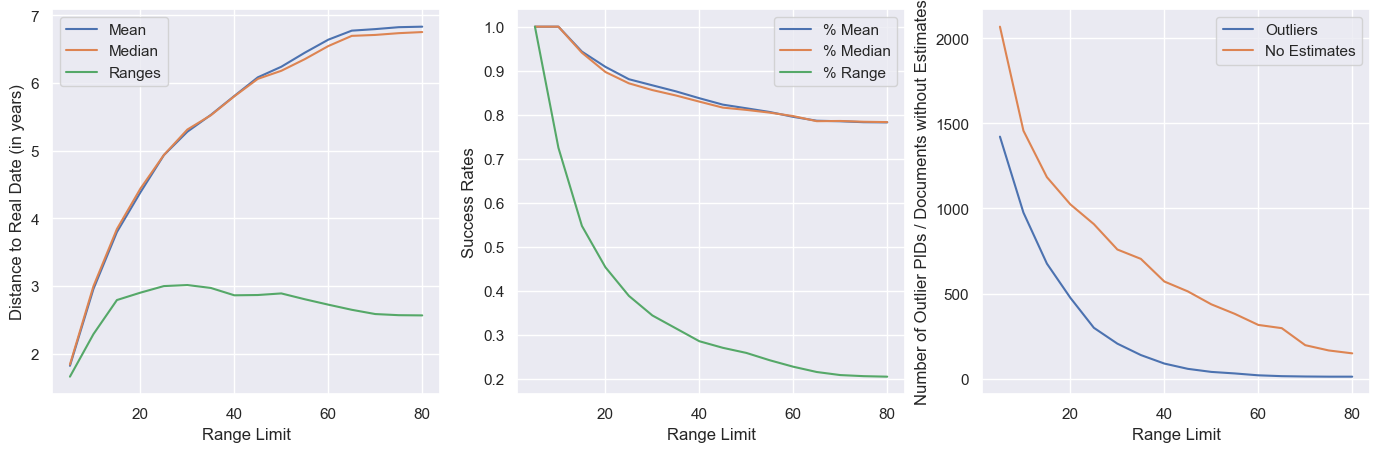

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(17, 5))

ax1 = sns.lineplot(results, x="Range Limit", y="Distance to Mean", ax=ax[0], label="Mean")
ax1 = sns.lineplot(results, x="Range Limit", y="Distance to Median", ax=ax[0], label="Median")
ax1 = sns.lineplot(results, x="Range Limit", y="Distance to Range", ax=ax[0], label="Ranges")
ax1.set_ylabel("Distance to Real Date (in years)")
ax2 = sns.lineplot(results, x="Range Limit", y="Success Percentage from Mean", ax=ax[1], label="% Mean")
ax2 = sns.lineplot(results, x="Range Limit", y="Success Percentage from Median", ax=ax[1], label="% Median")
ax2 = sns.lineplot(results, x="Range Limit", y="Success Percentage from Range", ax=ax[1], label="% Range")
ax2.set_ylabel("Success Rates")
ax3 = sns.lineplot(results, x="Range Limit", y="Outliers", ax=ax[2], label="Outliers")
ax3 = sns.lineplot(results, x="Range Limit", y="No Estimates", ax=ax[2], label="No Estimates")
ax3.set_ylabel("Number of Outlier PIDs / Documents without Estimates")

plt.legend()

As the above visualizations show, it is possible to achieve the desired results: by limiting the possible ranges to 20 years, the mean or median of the estimated range is within 10 years of the of the real date 90% of the time. Using the range on its own is less reliable. However, the downside is that by limiting the range to 20 years, almost half of the tablets do not receive and estimated date.

## Conclusions

To conclude, it was possible to successfully estimate dates for cuneiform documents from the first millennium BCE, based on disambiguated individuals, according to the parameters chosen to evaluate the results. However, this method is not applicable to approximately half of the texts in the current corpus. These are texts that do not have enough individuals attested in them, active for an *indicative range* of years. As noted above, while the data is rich, it is not equally distributed. There are too many individuals attested only once, and too few individuals with many years of activity. Lowering the range limit for years of activity significantly diminishes the amount of possible predictions. 

Furthermore, using the range itself has shown to be particularly unreliable, especially as opposed to the mean or the median of the range. While there is no significant difference between the mean and the median, the range is often too big. Even when diminishing the range limit for individuals, the predictions are not specific enough to be of use.

Thus, it seems that in order to make accurate predictions for a larger part of the available corpus, more parameters need to be taken into consideration. One of those factors that is available in the database is the role which any given person performs in the documents, such as buyer, seller, creditor, debtor, etc.; and the title they sometimes appear with, which indicates the position or profession a person has. These can have a more specific temporal span within the larger range of a person's years of activity. Applying such further limits that are not artificial might allow for further prediction on a larger number of the documents in the corpus.

## Reflection
  
The most difficult part of the project was cleaning the data and wrangling it into the format needed for my calculations. I needed to google quite often to find the functions that I needed. The main efforts that did not get into this report were additional visualizations. I tried to display the results in a way that also shows the success on different textual subtypes in a scatter plot, but the points overlapped in a way that would not have been indicative in a static visualization. Visualization methods for categorical data did not work well either with `Subtype` or `Archive` because both have over 100 possible categories. I spent about 1-2 days wrangling the data and writing the functions in the Appendix, and another day visualizing the data with seaborn and adding the text.